In [13]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import os
import glob

from sklearn.ensemble import RandomForestRegressor

In [3]:
#01
data0=pd.read_csv('input2.csv')

In [ ]:
data_rf_runs_per_ball=pd.read_csv('data_rf_runs_per_ball.csv')
data_rf_runs_per_ball

In [14]:
#adding pressure column
def pressure_generator(data0):
    data0['Pr1']=[(1 if x>=0.1 else 10*x) if x<=0.5 else 2*(1-x) for x in data0['p1']]
    data0['Pr2']=[(1 if x>=0.1 else 10*x) if x<=0.5 else 2*(1-x) for x in data0['p2']]
    return data0

In [15]:
def function1_RR_BR(data1):
    n0,m0=data1.shape
    no_balls=[0]*n0  
    balls=[0]*n0
    total_balls=[0]*n0  #total balls including no_balls
    BR=[0]*n0  # balls remaining
    total_runs=[0]*n0
    run_rate=[0]*n0

    no_balls[0]= 1 if data1.iloc[0]['runs_noballs']>0 else 0
    balls[0]=1
    total_balls[0]=balls[0]+no_balls[0]
    BR[0]=119
    total_runs[0]=data1.iloc[0]['runs_batsman']
    run_rate[0]=total_runs[0]

    first_innings_balls=0

    for i in range(1,n0):
        if data1.iloc[i]['match_pkey']==data1.iloc[i-1]['match_pkey']:
            no_balls[i]=no_balls[i-1]+1 if data1.iloc[i-1]['runs_noballs']>0 else no_balls[i-1]
            total_runs[i]=total_runs[i-1]+data1.iloc[i]['runs_batsman']

            if data1.iloc[i]['innings']==2 and data1.iloc[i-1]['innings']==1:
                first_innings_balls=(6*(data1.iloc[i-1]['over_num']-1)+data1.iloc[i-1]['ball_num'])

        else:
            no_balls[i]= 1 if data1.iloc[i]['runs_noballs']>0 else 0
            total_runs[i]=data1.iloc[i]['runs_batsman']
            first_innings_balls=0
        balls[i]=(6*(data1.iloc[i]['over_num']-1)+data1.iloc[i]['ball_num'])+first_innings_balls
        BR[i]=120-(6*(data1.iloc[i]['over_num']-1)+data1.iloc[i]['ball_num'])
        total_balls[i]=balls[i]+no_balls[i]
        run_rate[i]=total_runs[i]/total_balls[i]


    total_runs=pd.DataFrame(total_runs)
    run_rate=pd.DataFrame(run_rate)
    balls=pd.DataFrame(balls)
    no_balls=pd.DataFrame(no_balls)
    total_balls=pd.DataFrame(total_balls)
    BR=pd.DataFrame(BR)

    data1.insert(data1.shape[1],"no_balls",no_balls)#number of no balls in the innings
    data1.insert(data1.shape[1],"BB",balls) #Bowls bowled without counting no balls
    data1.insert(data1.shape[1],"Total_BB",total_balls)# balls+no_balls
    data1.insert(data1.shape[1],"BR",BR)# balls remaining in the innings
    data1.insert(data1.shape[1],"Runs",total_runs)#Total runs scored by all batsman (Byes not included) in the match till now
    data1.insert(data1.shape[1],"RR",run_rate)# run rate till that instant in tha match

    return data1

In [16]:
def function2_Pressure(data2):
    n2,m2=data2.shape

    final_pressure1=[0]*n2
    final_pressure2=[0]*n2
    final_pressure1[n2-1]=data2.iloc[n2-1]['Pr1']
    final_pressure2[n2-1]=data2.iloc[n2-1]['Pr2']


    for j in range(n2-2,-1,-1):
        if data2.iloc[j]['match_pkey'] != data2.iloc[j+1]['match_pkey']:
            final_pressure1[j]=data2.iloc[j]['Pr1']
            final_pressure2[j]=data2.iloc[j]['Pr2']
        elif data2.iloc[j]['innings']==1 and data2.iloc[j+1]['innings']==2:
            final_pressure1[j]=data2.iloc[j]['Pr1']
            final_pressure2[j]=data2.iloc[j]['Pr2']
        else:
            final_pressure1[j]=max(final_pressure1[j+1],data2.iloc[j]['Pr1'])
            final_pressure2[j]=max(final_pressure2[j+1],data2.iloc[j]['Pr2'])

    final_pressure1=pd.DataFrame(final_pressure1)
    final_pressure2=pd.DataFrame(final_pressure2)
    data2.insert(data2.shape[1],'Pr_bat',final_pressure1)
    data2.insert(data2.shape[1],'Pr_ball',final_pressure2)
    return data2

In [17]:
def function3_making_balls_unique(data3):
    n3,m3=data3.shape

    BR_unique=[-1]*n3
    BB_unique=[-1]*n3

    for i in range(0,n3-1):
        if data3.iloc[i]['BR']!=data3.iloc[i+1]['BR']:
            BR_unique[i]=data3.iloc[i]['BR']
        if data3.iloc[i]['Total_BB']!=data3.iloc[i+1]['Total_BB']:
            BB_unique[i]=data3.iloc[i]['Total_BB']        
    BR_unique[n3-1]=data3.iloc[n3-1]['BR']
    BB_unique[n3-1]=data3.iloc[n3-1]['Total_BB']

    BR_unique=pd.DataFrame(BR_unique)
    BB_unique=pd.DataFrame(BB_unique)
    data3.insert(data3.shape[1],'BR_unique',BR_unique)
    data3.insert(data3.shape[1],'BB_unique',BB_unique)
    return data3

In [79]:
def data_rf_runs_per_ball_generator(data4):
    # dropping row with wides, after doing this data4 contains only unique values of BB_unique for a match_pkey
    data4=data4[data4['BB_unique']>=0]
    # reseting the index after dropping some rows
    data4.reset_index(inplace = True, drop = True)

    # generating the training data for our random forest model as mentioned in paper
    data_rf_runs_per_ball=[]
    for i in data4['BR'].unique():
            data_rf_runs_per_ball.append((i,data4[data4['BR']==i]['runs_batsman'].mean()))
    data_rf_runs_per_ball=pd.DataFrame(data_rf_runs_per_ball)
    data_rf_runs_per_ball.rename(columns = {0:'BR', 1:'runs_per_balls'}, inplace = True)
    data_rf_runs_per_ball.to_csv('data_rf_runs_per_ball.csv',index=False)
    return data_rf_runs_per_ball

In [86]:
# updating the data4 table with random forest prediction

def Add_random_forest_model(data4,data_rf_runs_per_ball):
    # dropping row with wides, after doing this data4 contains only unique values of BB_unique for a match_pkey
    data4=data4[data4['BB_unique']>=0]
    # reseting the index after dropping some rows
    data4.reset_index(inplace = True, drop = True)
    
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    X=data_rf_runs_per_ball[['BR']]
    y=data_rf_runs_per_ball[['runs_per_balls']]
    regressor.fit(X, y)
    Random_forest_output=pd.DataFrame(regressor.predict(data4[['BR']]))
    data4.insert(data4.shape[1],'RF_output',Random_forest_output)
    return data4

In [20]:
# calculating smart_runs_batsman and smart_runs_bowler and adding them to data4

def smart_runs(data4):
    data4['smart_runs_batsman']=data4['runs_batsman']+data4['Pr_bat']*(data4['runs_batsman']-data4['RR']*data4['RF_output']/1.30)
    data4['smart_runs_bowler']=data4['runs_batsman']+data4['Pr_ball']*(data4['runs_batsman']-data4['RR']*data4['RF_output']/1.30)
    return data4

In [35]:
##Smart Wickets starting from here
# first we calculate all the default value which will be useful if a batsman played less than 15 innings or 
# less than 200 balls
# for that we separate the data into top_order, middle_order and lower_order

def batsman_list_generator(data4):
    top_order=data4[data4['position']<=4]
    middle_order=data4[data4['position']<=7][data4['position']>=5]
    lower_order=data4[data4['position']>7]

    # Default Smart Average for top_order, middle_order and lower_order batsmen
    SA_T_default=top_order['smart_runs_batsman'].sum()/top_order['is_dismissal'].sum()
    SA_M_default=middle_order['smart_runs_batsman'].sum()/middle_order['is_dismissal'].sum()
    SA_L_default=lower_order['smart_runs_batsman'].sum()/lower_order['is_dismissal'].sum()

    # Default Dismissal Rate for top_order, middle_order and lower_order batsmen
    top_order1=[]
    for i in range(len(top_order)):
        top_order1.append((top_order.iloc[i]['match_pkey'],top_order.iloc[i]['batsman_pkey']))
    top_order1=list(set(top_order1))
    DI_T_default=top_order['is_dismissal'].sum()/len(top_order1)

    # Default Dismissal Rate for top_order, middle_order and lower_order batsmen
    middle_order1=[]
    for i in range(len(middle_order)):
        middle_order1.append((middle_order.iloc[i]['match_pkey'],middle_order.iloc[i]['batsman_pkey']))
    middle_order1=list(set(middle_order1))
    DI_M_default=middle_order['is_dismissal'].sum()/len(middle_order1)

    # Default Dismissal Rate for top_order, middle_order and lower_order batsmen
    lower_order1=[]
    for i in range(len(lower_order)):
        lower_order1.append((lower_order.iloc[i]['match_pkey'],lower_order.iloc[i]['batsman_pkey']))
    lower_order1=list(set(lower_order1))
    DI_L_default=lower_order['is_dismissal'].sum()/len(lower_order1)

    # Default Smart Strike Rate for top_order, middle_order and lower_order batsmen
    SSR_T_default=top_order['smart_runs_batsman'].sum()/len(top_order['is_dismissal'])
    SSR_M_default=middle_order['smart_runs_batsman'].sum()/len(middle_order['is_dismissal'])
    SSR_L_default=lower_order['smart_runs_batsman'].sum()/len(lower_order['is_dismissal'])
    
    
    
    # manipulating data4 to get runs, dismissals, balls and no_innings for each player
    # Calculating Smart Average (SA), Smart strike rate (SSR), R_0 and R for each batsmen
    # R_0=SSR+SA
    # Batsmen Rating  R=(R_0-R_0_min)/(R_0_max-R_0_min)  
    # adding it to the batsman_list1 dataframe
    batsman_list=[]
    for i in data4['batsman_pkey'].unique():
        batsman_list.append((i,data4[data4['batsman_pkey']==i]['smart_runs_batsman'].sum(),
                             data4[data4['batsman_pkey']==i]['runs_batsman'].sum(),
                  len(data4[data4['batsman_pkey']==i][data4['is_dismissal']!=0]),len(data4[data4['batsman_pkey']==i]),
                 len(data4[data4['batsman_pkey']==i]['match_pkey'].unique())))
    batsman_list=pd.DataFrame(batsman_list)
    batsman_list.rename(columns = {0:'batsman_pkey', 1:'smart_runs',2:'runs',3:'dismissals', 4: 'balls', 5: 'no_innings'}, inplace = True)
    #here matches != innings as a batsman may not bat in a match which will not count towards the no of innings
    batsman_list1=batsman_list.copy()

    SA=[]
    SSR=[]
    average_nominal=[]
    strike_rate_nominal=[]
    for i in batsman_list['batsman_pkey']:
        Smart_Runs=batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['smart_runs']
        Runs=batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['runs']
        No_Dismissals=batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['dismissals']
        balls=batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['balls']

        if batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['no_innings']>=15:
            SA.append(Smart_Runs/No_Dismissals)
        else:
            NI_T=len(top_order[top_order['batsman_pkey']==i]['match_pkey'].unique())
            NI_M=len(middle_order[middle_order['batsman_pkey']==i]['match_pkey'].unique())
            NI_L=len(lower_order[lower_order['batsman_pkey']==i]['match_pkey'].unique())
            NI=NI_T+NI_M+NI_L
            SA_0=(NI_T*SA_T_default+NI_M*SA_M_default+NI_L*SA_L_default)/NI
            DI_0=(NI_T*DI_T_default+NI_M*DI_M_default+NI_L*DI_L_default)/NI
            SA.append((Smart_Runs+(15-NI)*DI_0*SA_0)/(No_Dismissals+(15-NI)*DI_0))


        if batsman_list[batsman_list['batsman_pkey']==i].iloc[0]['balls']>=200:
            SSR.append(100*Smart_Runs/balls)
        else:
            BF_T=len(top_order[top_order['batsman_pkey']==i]['match_pkey'].unique())
            BF_M=len(middle_order[middle_order['batsman_pkey']==i]['match_pkey'].unique())
            BF_L=len(lower_order[lower_order['batsman_pkey']==i]['match_pkey'].unique())
            BF=BF_T+BF_M+BF_L
            SSR_0=(BF_T*SSR_T_default+BF_M*SSR_M_default+BF_L*SSR_L_default)/BF
            DI_0=(NI_T*DI_T_default+NI_M*DI_M_default+NI_L*DI_L_default)/NI
            SSR.append(100*(Smart_Runs+(200-BF)*SSR_0)/200)
        
        average_nominal.append(Runs/No_Dismissals) 
        strike_rate_nominal.append(100*Runs/balls)
        


    SA=pd.DataFrame(SA)
    SSR=pd.DataFrame(SSR)
    average_nominal=pd.DataFrame(average_nominal)
    strike_rate_nominal=pd.DataFrame(strike_rate_nominal)

    batsman_list1.insert(batsman_list1.shape[1],'average_nominal',average_nominal)#Smart Average
    batsman_list1.insert(batsman_list1.shape[1],'strike_rate_nominal',strike_rate_nominal)#Smart Strike Rate    
    batsman_list1['R_0_nominal']=(batsman_list1['average_nominal']-batsman_list1['average_nominal'].min())/(batsman_list1['average_nominal'].max()-batsman_list1['average_nominal'].min())+(batsman_list1['strike_rate_nominal']-batsman_list1['strike_rate_nominal'].min())/(batsman_list1['strike_rate_nominal'].max()-batsman_list1['strike_rate_nominal'].min())
    batsman_list1['R_nominal']=(batsman_list1['R_0_nominal']-batsman_list1['R_0_nominal'].min())/(batsman_list1['R_0_nominal'].max()-batsman_list1['R_0_nominal'].min())
     
    batsman_list1.insert(batsman_list1.shape[1],'SA',SA)#Smart Average
    batsman_list1.insert(batsman_list1.shape[1],'SSR',SSR)#Smart Strike Rate
    batsman_list1['R_0']=(batsman_list1['SA']-batsman_list1['SA'].min())/(batsman_list1['SA'].max()-batsman_list1['SA'].min())+(batsman_list1['SSR']-batsman_list1['SSR'].min())/(batsman_list1['SSR'].max()-batsman_list1['SSR'].min())
    batsman_list1['R']=(batsman_list1['R_0']-batsman_list1['R_0'].min())/(batsman_list1['R_0'].max()-batsman_list1['R_0'].min())
    return batsman_list1

In [46]:
def combine_batsmanR_data(data5):
    temp2=[]
    # Adding R for each batsmen in data5
    for i in data5['batsman_pkey']:
        temp2.append(batsman_list1[batsman_list1['batsman_pkey']==i].iloc[0]['R'])
    temp2=pd.DataFrame(temp2)
    data5.insert(data5.shape[1],'R',temp2)

    # Finally calculating smart wickets based on Pr_ball and R value whenever there is dismissal
    def func(df):
        if df['is_dismissal']==0:
            return 0
        elif df['BR']>=18:
            return df['Pr_ball']+df['R']
        else:
            return df['Pr_ball']+df['R']*df['BR']/18

    data5['Smart_wicket']=data5.apply(func,axis=1)
    return data5

In [43]:
#bowler wise
def bowler_list_generator(data5):
    bowler_list=[]
    for i in data5['bowler_pkey'].unique():
        bowler_list.append((i,data5[data5['bowler_pkey']==i]['Smart_wicket'].sum(),
                            len(data5[data5['bowler_pkey']==i][data5['is_dismissal']!=0]),
                            len(data5[data5['bowler_pkey']==i]['match_pkey'].unique()),
                            data5[data5['bowler_pkey']==i]['smart_runs_bowler'].sum(),
                            data5[data5['bowler_pkey']==i]['runs_batsman'].sum(), len(data5[data5['bowler_pkey']==i]),
                len(data5[data5['bowler_pkey']==i][data5['runs_noballs']>0])))
    bowler_list=pd.DataFrame(bowler_list)
    bowler_list.rename(columns = {0:'bowler_pkey', 1:'Smart_wicket',2:'Actual_wicket',3: 'no_innings_bowled', 
                                  4:'smart_runs_conceded', 5:'Actual_runs_conceded',
                                   6: 'balls', 7:'no_balls'}, inplace = True)
    
    smart_bowl_average=[]
    economy_rate=[]
    bowl_average_nominal=[]
    economy_rate_nominal=[]
    for i in bowler_list['bowler_pkey']:
        Smart_wicket=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['Smart_wicket']
        Actual_wicket=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['Actual_wicket']
        smart_runs_conceded=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['smart_runs_conceded']
        Actual_runs_conceded=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['Actual_runs_conceded']
        balls=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['balls']
        no_balls=bowler_list[bowler_list['bowler_pkey']==i].iloc[0]['no_balls']
        
        if Actual_wicket==0:
            Actual_wicket=-1*Actual_runs_conceded
            Smart_wicket=-1*smart_runs_conceded
        
        smart_bowl_average.append(smart_runs_conceded/Smart_wicket)
        economy_rate.append(smart_runs_conceded/(balls-no_balls))
        bowl_average_nominal.append(Actual_runs_conceded/Actual_wicket)
        economy_rate_nominal.append(Actual_runs_conceded/(balls-no_balls))
    
    smart_bowl_average=pd.DataFrame(smart_bowl_average)
    economy_rate=pd.DataFrame(economy_rate)
    bowl_average_nominal=pd.DataFrame(bowl_average_nominal)
    economy_rate_nominal=pd.DataFrame(economy_rate_nominal)
    
    bowler_list.insert(bowler_list.shape[1],'smart_bowl_average',smart_bowl_average)
    bowler_list.insert(bowler_list.shape[1],'economy_rate',economy_rate)    
    bowler_list.insert(bowler_list.shape[1],'bowl_average_nominal',bowl_average_nominal)
    bowler_list.insert(bowler_list.shape[1],'economy_rate_nominal',economy_rate_nominal) 
    return bowler_list

In [ ]:
#impact score

In [67]:
def impact_score(data6):
    data6['r0_par_runs']=data6['RF_output']*data6['RR']/1.3
    IS_bat=[]
    IS_bowl=[]
    for i in data6['match_pkey'].unique():
        for j in data6[data6['match_pkey']==i]['batsman_pkey'].unique():
            IS_bat.append((i,j,data6[data6['match_pkey']==i][data6['batsman_pkey']==j]['smart_runs_batsman'].sum()))
        for j in data6[data6['match_pkey']==i]['bowler_pkey'].unique():
            IS_bowl.append((i,j,(data6[data6['match_pkey']==i][data6['bowler_pkey']==j]['r0_par_runs'].sum()-data6[data6['match_pkey']==i][data6['bowler_pkey']==j]['smart_runs_bowler'].sum())+25*data6[data6['match_pkey']==i][data6['bowler_pkey']==j]['Smart_wicket'].sum()))
    IS_bat=pd.DataFrame(IS_bat)
    IS_bowl=pd.DataFrame(IS_bowl)
    IS_bat.rename(columns = {0:'match_pkey', 1:'batsman_pkey',2:'IS_bat'}, inplace = True)
    IS_bowl.rename(columns = {0:'match_pkey', 1:'bowler_pkey',2:'IS_bowl'}, inplace = True)
    return IS_bat,IS_bowl

In [94]:
def main_function(data):
    data=pressure_generator(data)
    data=function1_RR_BR(data)
    data=function2_Pressure(data)
    data=function3_making_balls_unique(data)
    data_rf_runs_per_ball=data_rf_runs_per_ball_generator(data)
    data=Add_random_forest_model(data,data_rf_runs_per_ball)
    data=smart_runs(data)
    batsman_list=batsman_list_generator(data4) 
    data=combine_batsmanR_data(data)
    bowler_list=bowler_list_generator(data)
    IS_bat,IS_bowl=impact_score(data)
    return data, batsman_list, bowler_list, IS_bat, IS_bowl

In [ ]:
#pressure_generator
#function1_RR_BR
#function2_Pressure
#function3_making_balls_unique
#data_rf_runs_per_ball_generator
#Add_random_forest_model
#smart_runs


#batsman_list_generator
#combine_batsmanR_data
#bowler_list_generator
#impact_score

In [98]:
data0=pressure_generator(data0)
data1=data0.copy()
data1=function1_RR_BR(data1)
data2=data1.copy()
data2=function2_Pressure(data2)
data3=data2.copy()
data3=function3_making_balls_unique(data3)

In [87]:
data4=data3.copy()
data_rf_runs_per_ball=data_rf_runs_per_ball_generator(data4)

In [89]:
data4=Add_random_forest_model(data4,data_rf_runs_per_ball)
data4=smart_runs(data4)
data4


,match_pkey,innings,over_num,ball_num,ball_num_unique,batsman_pkey,bowler_pkey,is_dismissal,runs,runs_batsman,...,BR,Runs,RR,Pr_bat,Pr_ball,BR_unique,BB_unique,RF_output,smart_runs_batsman,smart_runs_bowler
0,1.0,1.0,1.0,1.0,1.0,11.0,2.0,0.0,1.0,1.0,...,119.0,1.0,1.000000,1.0,1.00,119.0,1.0,0.812905,1.374689,1.374689
1,1.0,1.0,1.0,2.0,2.0,47.0,2.0,0.0,0.0,0.0,...,118.0,1.0,0.500000,1.0,1.00,118.0,2.0,0.954081,-0.366954,-0.366954
2,1.0,1.0,1.0,3.0,3.0,47.0,2.0,0.0,0.0,0.0,...,117.0,1.0,0.333333,1.0,1.00,117.0,3.0,0.994016,-0.254876,-0.254876
3,1.0,1.0,1.0,4.0,4.0,47.0,2.0,0.0,0.0,0.0,...,116.0,1.0,0.250000,1.0,1.00,116.0,4.0,1.007710,-0.193790,-0.193790
4,1.0,1.0,1.0,5.0,5.0,47.0,2.0,0.0,4.0,4.0,...,115.0,5.0,1.000000,1.0,1.00,115.0,5.0,1.004738,7.227125,7.227125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377749,998.0,2.0,19.0,3.0,3.0,577.0,1003.0,0.0,2.0,1.0,...,9.0,279.0,1.207792,0.6,0.12,-1.0,231.0,1.609624,0.702727,0.940545
377750,998.0,2.0,19.0,3.0,4.0,577.0,1003.0,0.0,6.0,6.0,...,9.0,285.0,1.228448,0.2,0.04,9.0,232.0,1.609624,6.895794,6.179159
377751,998.0,2.0,19.0,4.0,5.0,577.0,1003.0,0.0,1.0,1.0,...,8.0,286.0,1.227468,0.1,0.02,8.0,233.0,1.594911,0.949407,0.989881
377752,998.0,2.0,19.0,5.0,6.0,475.0,1003.0,0.0,1.0,1.0,...,7.0,287.0,1.226496,0.1,0.02,7.0,234.0,1.580704,0.950867,0.990173


In [90]:
batsman_list=batsman_list_generator(data4) 
batsman_list

,batsman_pkey,smart_runs,runs,dismissals,balls,no_innings,average_nominal,strike_rate_nominal,R_0_nominal,R_nominal,SA,SSR,R_0,R
0,11.0,2607.320848,2521.0,60,1838,74,42.016667,137.159956,0.342900,0.548640,43.455347,141.856412,0.941231,0.547056
1,47.0,628.223848,532.0,21,380,21,25.333333,140.000000,0.350000,0.560000,29.915421,165.322065,0.838951,0.480519
2,12.0,1417.128569,1250.0,38,768,48,32.894737,162.760417,0.406901,0.651042,37.292857,184.521949,1.032975,0.606740
3,21.0,3412.371715,2963.0,67,1828,84,44.223881,162.089716,0.405224,0.648359,50.930921,186.672413,1.247487,0.746289
4,44.0,1613.073432,1514.0,60,1149,69,25.233333,131.766754,0.329417,0.527067,26.884557,140.389333,0.685545,0.380721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,1247.0,37.371615,34.0,2,21,5,17.000000,161.904762,0.404762,0.647619,20.694462,144.492406,0.610142,0.331668
2571,1258.0,0.314404,1.0,0,3,2,inf,33.333333,NaN,NaN,10.528873,99.739872,0.263683,0.106282
2572,507.0,2.390831,5.0,0,5,2,inf,100.000000,NaN,NaN,10.818466,100.778086,0.272530,0.112037
2573,1261.0,3.022848,7.0,1,10,2,7.000000,70.000000,0.175000,0.280000,9.571677,101.094094,0.255135,0.100721


In [91]:
data5=data4.copy()
data5=combine_batsmanR_data(data5)
data5

,match_pkey,innings,over_num,ball_num,ball_num_unique,batsman_pkey,bowler_pkey,is_dismissal,runs,runs_batsman,...,RR,Pr_bat,Pr_ball,BR_unique,BB_unique,RF_output,smart_runs_batsman,smart_runs_bowler,R,Smart_wicket
0,1.0,1.0,1.0,1.0,1.0,11.0,2.0,0.0,1.0,1.0,...,1.000000,1.0,1.00,119.0,1.0,0.812905,1.374689,1.374689,0.547056,0.0
1,1.0,1.0,1.0,2.0,2.0,47.0,2.0,0.0,0.0,0.0,...,0.500000,1.0,1.00,118.0,2.0,0.954081,-0.366954,-0.366954,0.480519,0.0
2,1.0,1.0,1.0,3.0,3.0,47.0,2.0,0.0,0.0,0.0,...,0.333333,1.0,1.00,117.0,3.0,0.994016,-0.254876,-0.254876,0.480519,0.0
3,1.0,1.0,1.0,4.0,4.0,47.0,2.0,0.0,0.0,0.0,...,0.250000,1.0,1.00,116.0,4.0,1.007710,-0.193790,-0.193790,0.480519,0.0
4,1.0,1.0,1.0,5.0,5.0,47.0,2.0,0.0,4.0,4.0,...,1.000000,1.0,1.00,115.0,5.0,1.004738,7.227125,7.227125,0.480519,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377749,998.0,2.0,19.0,3.0,3.0,577.0,1003.0,0.0,2.0,1.0,...,1.207792,0.6,0.12,-1.0,231.0,1.609624,0.702727,0.940545,0.395344,0.0
377750,998.0,2.0,19.0,3.0,4.0,577.0,1003.0,0.0,6.0,6.0,...,1.228448,0.2,0.04,9.0,232.0,1.609624,6.895794,6.179159,0.395344,0.0
377751,998.0,2.0,19.0,4.0,5.0,577.0,1003.0,0.0,1.0,1.0,...,1.227468,0.1,0.02,8.0,233.0,1.594911,0.949407,0.989881,0.395344,0.0
377752,998.0,2.0,19.0,5.0,6.0,475.0,1003.0,0.0,1.0,1.0,...,1.226496,0.1,0.02,7.0,234.0,1.580704,0.950867,0.990173,0.358288,0.0


In [92]:
bowler_list=bowler_list_generator(data5)
bowler_list

,bowler_pkey,Smart_wicket,Actual_wicket,no_innings_bowled,smart_runs_conceded,Actual_runs_conceded,balls,no_balls,smart_bowl_average,economy_rate,bowl_average_nominal,economy_rate_nominal
0,2.0,78.550841,61,57,1624.353694,1510.0,1244,5,20.679011,1.311020,24.754098,1.218725
1,30.0,35.692727,27,24,634.785168,594.0,479,0,17.784720,1.325230,22.000000,1.240084
2,22.0,1.487070,1,3,49.387103,42.0,30,0,33.211013,1.646237,42.000000,1.400000
3,36.0,198.274976,166,116,2765.754617,2900.0,2624,3,13.949086,1.055229,17.469880,1.106448
4,24.0,52.950804,41,52,1147.713888,1117.0,950,0,21.675098,1.208120,27.243902,1.175789
...,...,...,...,...,...,...,...,...,...,...,...,...
1881,1143.0,0.000000,0,2,36.721750,37.0,30,0,-1.000000,1.224058,-1.000000,1.233333
1882,1205.0,0.000000,0,2,39.781173,33.0,18,0,-1.000000,2.210065,-1.000000,1.833333
1883,602.0,0.403660,1,3,101.847881,95.0,55,0,252.311303,1.851780,95.000000,1.727273
1884,1261.0,2.397221,2,5,156.493014,143.0,97,1,65.281008,1.630136,71.500000,1.489583


In [93]:
data6=data5.copy()
IS_bat,IS_bowl=impact_score(data6)

In [96]:
data5.to_csv('results_smart_stats.csv', index=False)
batsman_list1.to_csv('smart_stats_by_batsman.csv',index=False)
bowler_list.to_csv('smart_stats_by_bowler.csv',index=False)

In [97]:
IS_bat.to_csv('impact_score_batsman.csv',index=False)
IS_bowl.to_csv('impact_score_bowler.csv',index=False)

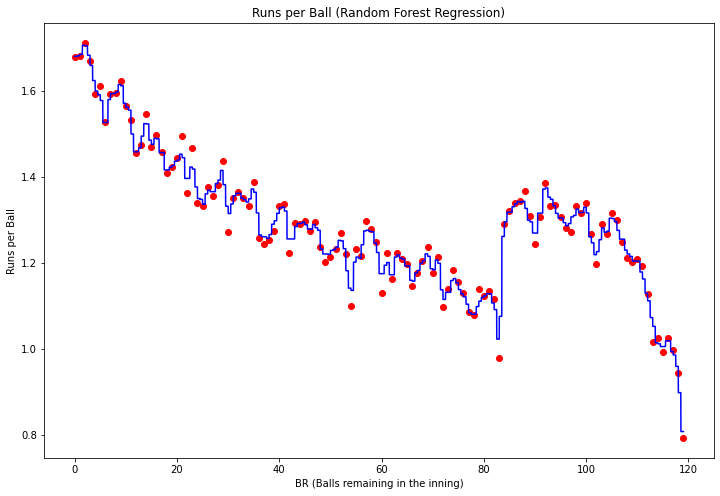

In [60]:
# training the random forest model
from sklearn.ensemble import RandomForestRegressor
regressor1 = RandomForestRegressor(n_estimators = 10, random_state = 3)
X=data_rf_runs_per_ball[['BR']]
y=data_rf_runs_per_ball[['runs_per_balls']]
regressor1.fit(X, y)

# plotting the random forest model to visualise
import matplotlib.pyplot as plt

X1=X.to_numpy()
y1=y.to_numpy()
X_grid = np.arange(min(X1), max(X1), 0.001)
X_grid = X_grid.reshape((len(X_grid), 1))
f=plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.scatter(X1, y1, color = 'red')
plt.plot(X_grid, regressor1.predict(X_grid), color = 'blue')

plt.title('Runs per Ball (Random Forest Regression)')
plt.xlabel('BR (Balls remaining in the inning)')
plt.ylabel('Runs per Ball')
plt.show()